# Experimentation Only

In [1]:
import sys
!{sys.executable} -m pip install tqdm

You are using pip version 9.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from datetime import datetime
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm, tqdm_notebook
import json
import requests
%matplotlib inline

#For Prediction
from sklearn import metrics
from sklearn import preprocessing, cross_validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.layers import Dense, Dropout, Input, LSTM, Reshape, Flatten, Activation
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [153]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
hist = pd.DataFrame(json.loads(res.content.decode('utf-8'))['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
hist.head()

# hist = pd.read_csv('Datasets/gemini_BTCUSD_1hr_mod.csv')
# hist.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2013-12-12,899.98,940.98,839.51,919.93,9913.21,8798283.62
2013-12-13,936.77,989.89,882.11,899.98,17372.49,16173632.88
2013-12-14,908.94,947.93,875.11,936.77,11589.80,10532106.73
2013-12-15,919.88,927.90,837.98,908.94,15165.03,13302074.90
2013-12-16,759.92,924.94,714.03,919.88,41325.66,32899151.97


In [154]:
#hist = hist.drop(['high','low','open','volumefrom','volumeto'], axis=1)
#hist = hist.drop(['Unix Timestamp','Date','Symbol','Open','High','Low','Volume'], axis=1)
#hist = hist.drop(['Date','Symbol','Unix Timestamp','Low','High'], axis=1)
hist.tail()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2019-05-31,8550.67,8570.78,8116.00,8276.25,60143.23,5.020565e+08
2019-06-01,8555.87,8619.21,8459.65,8550.67,26884.15,2.297370e+08
2019-06-02,8737.91,8819.90,8547.48,8555.87,25506.14,2.217081e+08
2019-06-03,8114.49,8740.24,8073.18,8737.91,63486.15,5.349722e+08
2019-06-04,7711.69,8114.49,7602.05,8114.49,73219.34,5.780534e+08


In [155]:
print(len(hist))

2001


In [156]:
print("checking if any null values are present\n", hist.isna().sum())

checking if any null values are present
 close         0
high          0
low           0
open          0
volumefrom    0
volumeto      0
dtype: int64


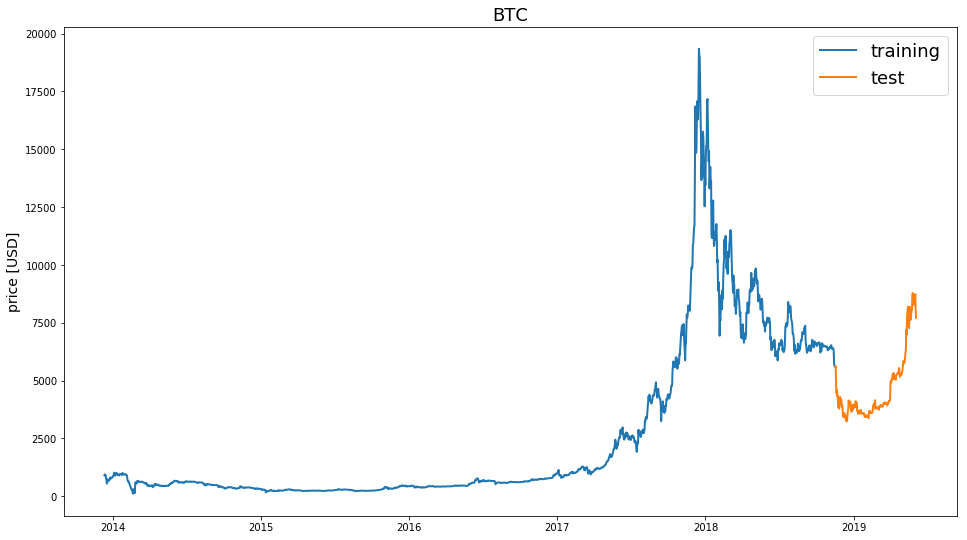

In [157]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

def line_plot(line1, line2, label1=None, label2=None, title=''):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)
    
train, test = train_test_split(hist, test_size=0.1)
line_plot(train.close, test.close, 'training', 'test', 'BTC')

In [158]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with
        respect to first entry.
    """
    return df / df.iloc[0] - 1

def extract_window_data(df, window=7, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of
        length `window`.
    """
    window_data = []
    for idx in range(len(df) - window):
        tmp = df[idx: (idx + window)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df, window=7, zero_base=True, test_size=0.1):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window, zero_base)
    X_test = extract_window_data(test_data, window, zero_base)
    
    # extract targets
    y_train = train_data.close[window:].values
    y_test = test_data.close[window:].values
    if zero_base:
        y_train = y_train / train_data.close[:-window].values - 1
        y_test = y_test / test_data.close[:-window].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

train, test, X_train, X_test, y_train, y_test = prepare_data(hist)

In [159]:
print(X_train.shape)
print(X_train.shape)
print(y_test.shape)
print(y_test.shape)

(1794, 7, 6)
(1794, 7, 6)
(193,)
(193,)


In [160]:
TIME_STEPS = 7
BATCH_SIZE_OUT = 4 # 16 was better
LR = 0.005
# epochs = 150
EPOCHS = 50

In [161]:
def create_generator():
#     generator=Sequential()
#     generator.add(Dense(units=128,input_dim=8))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=256))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=512))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=8, activation='tanh'))
    
#     #generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer(), metrics=['accuracy'])
#     generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # 6 below = x_t.shape[2]
#     generator = Sequential()
#     #generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 6), dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform', return_sequences=False)) 
#     # stateful = true breaks the model (https://github.com/keras-team/keras/issues/9385)
#     generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 1), return_sequences=True)) 
#     generator.add(Dense(8,activation='relu'))
#     generator.add(Dropout(0.7))
#     generator.add(LSTM(8, return_sequences=False))
#     generator.add(Dense(1,activation='sigmoid'))
#     #generator.add(Reshape((TIME_STEPS, 1)))
#     optimizer = RMSprop(lr=LR, decay=3e-8)
#     #generator.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
#     generator.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
    
    
    generator = Sequential()
    generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 6), return_sequences=False))
    generator.add(LeakyReLU(0.5))
    generator.add(Dropout(0.5))
    generator.add(Dense(6))
    generator.add(Activation('tanh'))
    optimizer = RMSprop(lr=0.005, clipvalue=1.)
    generator.compile(loss='mean_squared_error', optimizer=optimizer)

    return generator
g=create_generator()
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (4, 16)                   1472      
_________________________________________________________________
leaky_re_lu_101 (LeakyReLU)  (4, 16)                   0         
_________________________________________________________________
dropout_101 (Dropout)        (4, 16)                   0         
_________________________________________________________________
dense_135 (Dense)            (4, 6)                    102       
_________________________________________________________________
activation_33 (Activation)   (4, 6)                    0         
Total params: 1,574
Trainable params: 1,574
Non-trainable params: 0
_________________________________________________________________


In [176]:
def create_discriminator():
    optimizer = RMSprop(lr=0.0002, decay=6e-8)

    discriminator=Sequential()
    #discriminator.add(Dense(units=512, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 1)))
    discriminator.add(Dense(units=16, batch_input_shape=(8, TIME_STEPS, 6)))
    
    #discriminator.add(Dense(units=512,input_dim=6))
    discriminator.add(LeakyReLU(0.5))
    discriminator.add(Dropout(0.5))
       
    
#     discriminator.add(Dense(units=256))
#     discriminator.add(LeakyReLU(0.2))
#     discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=8))
    discriminator.add(LeakyReLU(0.5))
    discriminator.add(Dropout(0.5))
    
    #discriminator.add(Reshape((5, 1)))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    #discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    discriminator.compile(loss='mean_squared_error', optimizer=optimizer)

#     discriminator = Sequential()
#     discriminator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 6), dropout=0.0, recurrent_dropout=0.0, kernel_initializer='random_uniform', return_sequences=False)) 
#     discriminator.add(Dense(8,activation='relu'))
#     discriminator.add(Dropout(0.7))
#     discriminator.add(Dense(1,activation='sigmoid'))

#     discriminator.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    return discriminator
d =create_discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_143 (Dense)            (8, 7, 16)                112       
_________________________________________________________________
leaky_re_lu_107 (LeakyReLU)  (8, 7, 16)                0         
_________________________________________________________________
dropout_107 (Dropout)        (8, 7, 16)                0         
_________________________________________________________________
dense_144 (Dense)            (8, 7, 8)                 136       
_________________________________________________________________
leaky_re_lu_108 (LeakyReLU)  (8, 7, 8)                 0         
_________________________________________________________________
dropout_108 (Dropout)        (8, 7, 8)                 0         
_________________________________________________________________
dense_145 (Dense)            (8, 7, 1)                 9         
Total para

In [177]:
def create_gan(discriminator, generator):
    optimizer = RMSprop(lr=0.0001, decay=3e-8)
    discriminator.trainable=False
    gan_input = Input(shape=(TIME_STEPS, 6)) # x_t.shape[2] = 6
    #Input(shape=(None, latent_dim))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    #gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    gan.compile(loss='mean_squared_error', optimizer=optimizer)
    return gan
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 7, 6)              0         
_________________________________________________________________
sequential_67 (Sequential)   multiple                  1574      
_________________________________________________________________
sequential_71 (Sequential)   multiple                  257       
Total params: 1,831
Trainable params: 1,574
Non-trainable params: 257
_________________________________________________________________


In [178]:
import keras.backend as K

adversarial_loss = []
discrimator_loss = []
gen_samples = []

#K.clear_session()
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)
#(X_train, y_train, X_val, X_test, y_val, y_test) = load_data(x_train_out, x_test_out, BATCH_SIZE_OUT)

def training(epochs=1, batch_size=128):
    global adversarial_loss
    global discrimator_loss
    global gen_samples
    
    global generator
    global discriminator
    global gan

    global X_train
    global X_test
    global y_train
    global y_test
    
    for e in range(1, epochs+1 ):
        print("Epoch %d" %e)
        for i in tqdm(range(batch_size)):
            #generate  random noise as an input  to  initialize the  generator
            #noise = np.random.normal(0,1, [BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]])
            #print(X_train.shape)
            
            noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
            
            # Generate fake prices from noised input
            generated_prices = generator.predict(noise)
            
            # Get a random set of real prices
            prices_batch = X_train[np.random.randint(low=0,high=X_train.shape[0],size=BATCH_SIZE_OUT)]
            
            
            dim_0 = generated_prices.shape[0] - TIME_STEPS
            dim_0 = generated_prices.shape[0]
            gen_prices = np.zeros((dim_0, TIME_STEPS, 6))
            
            for j in range(dim_0):
                gen_prices[j] = generated_prices[j]
            

#             print('Shapes 1')
#             print(noise.shape)
#             print(prices_batch.shape)
#             print(generated_prices.shape)     
#             print(gen_prices.shape)
#             print('>>>>>>>>>>>gen_prices>>>>>>>')            
#             print(gen_prices)
#             print(prices_batch)
#             #print(generated_prices)
            
            #Construct different batches of real and fake data 
            X = np.concatenate([prices_batch, gen_prices])
            
            # Labels for generated and real data
            #y_dis = np.zeros(2*batch_size)
            #y_dis = np.zeros(shape=(2*BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]))
            y_dis = np.zeros(shape=(X.shape[0], TIME_STEPS, 1))
            #y_dis[:batch_size]=0.9
            y_dis[:int((X.shape[0]/2))]=0.9
            #y_dis[0,:,batch_size]=0.9
            
#             print('Shapes 2')
#             print(X.shape)
#             print(y_dis.shape)
#             print('>>>>>>>>>>>x>>>>>>>')
#             print(X)
#             print('>>>>>>>>>>>y_dis>>>>>>>')            
#             print(y_dis)
            
            #Pre train discriminator on fake and real data before starting the gan. 
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            #noise = np.random.normal(0,1, [batch_size, 8])
            #y_gen = np.ones(batch_size)
            noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
            #y_gen = np.ones(shape=(noise.shape[0], TIME_STEPS, X_train.shape[2]))
            y_gen = np.ones(BATCH_SIZE_OUT)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
#             print('Shapes 3')
#             print(noise.shape)
#             print(y_gen.shape)
            
            #training the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            a_loss = gan.train_on_batch(noise, y_gen)
            
            if i == (batch_size-1):
                #log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
                #log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
                log_mesg = "%d: [D loss: %f]" % (e, d_loss)
                log_mesg = "%s  [A loss: %f]" % (log_mesg, a_loss)
                print(log_mesg)
                
            discrimator_loss.append(d_loss)
            adversarial_loss.append(a_loss)
            
#         if e == 1 or e % 5 == 0:
#             # generate synthetic dataset
#             gen_samples_set = []
#             for batch_idx in range(int(len(X_train) / batch_size)):
#             # for batch_idx in range(int(len(X_train) / 100)):
#                 # noise= np.random.normal(loc=0, scale=1, size=[100, 100])
#                 #noise= np.random.normal(0,1, [batch_size, 8])
#                 noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
#                 generated_data = generator.predict(noise)
#                 gen_samples_set.append(generated_data)

#             gen_samples = np.vstack(gen_samples_set)

In [183]:
#training(400,128)
training(100,12)


 33%|███▎      | 4/12 [00:00<00:00, 33.77it/s]

Epoch 1



 50%|█████     | 6/12 [00:00<00:00, 57.48it/s]

1: [D loss: 0.180821]  [A loss: 0.274208]
Epoch 2



 33%|███▎      | 4/12 [00:00<00:00, 36.20it/s]

2: [D loss: 0.203186]  [A loss: 0.348907]
Epoch 3



 33%|███▎      | 4/12 [00:00<00:00, 30.73it/s]

3: [D loss: 0.194236]  [A loss: 0.306907]
Epoch 4



 25%|██▌       | 3/12 [00:00<00:00, 26.40it/s]

4: [D loss: 0.197502]  [A loss: 0.303800]
Epoch 5



 50%|█████     | 6/12 [00:00<00:00, 55.07it/s]

5: [D loss: 0.196186]  [A loss: 0.313675]
Epoch 6



 42%|████▏     | 5/12 [00:00<00:00, 45.14it/s]

6: [D loss: 0.194302]  [A loss: 0.263228]
Epoch 7



 42%|████▏     | 5/12 [00:00<00:00, 49.08it/s]

7: [D loss: 0.187527]  [A loss: 0.301212]
Epoch 8



 58%|█████▊    | 7/12 [00:00<00:00, 67.33it/s]

8: [D loss: 0.185182]  [A loss: 0.294353]
Epoch 9



 50%|█████     | 6/12 [00:00<00:00, 54.56it/s]

9: [D loss: 0.180722]  [A loss: 0.323189]
Epoch 10



 58%|█████▊    | 7/12 [00:00<00:00, 64.53it/s]

10: [D loss: 0.203407]  [A loss: 0.324629]
Epoch 11



 42%|████▏     | 5/12 [00:00<00:00, 47.08it/s]

11: [D loss: 0.199655]  [A loss: 0.316996]
Epoch 12



  0%|          | 0/12 [00:00<?, ?it/s]

12: [D loss: 0.205238]  [A loss: 0.312014]
Epoch 13



 42%|████▏     | 5/12 [00:00<00:00, 43.11it/s]

13: [D loss: 0.201868]  [A loss: 0.285583]
Epoch 14



 42%|████▏     | 5/12 [00:00<00:00, 45.50it/s]

14: [D loss: 0.207570]  [A loss: 0.318250]
Epoch 15



 25%|██▌       | 3/12 [00:00<00:00, 29.90it/s]

15: [D loss: 0.196069]  [A loss: 0.306722]
Epoch 16



 42%|████▏     | 5/12 [00:00<00:00, 46.50it/s]

16: [D loss: 0.191067]  [A loss: 0.351482]
Epoch 17



 42%|████▏     | 5/12 [00:00<00:00, 47.00it/s]

17: [D loss: 0.203253]  [A loss: 0.350766]
Epoch 18



 42%|████▏     | 5/12 [00:00<00:00, 45.43it/s]

18: [D loss: 0.188408]  [A loss: 0.370925]
Epoch 19



 42%|████▏     | 5/12 [00:00<00:00, 46.18it/s]

19: [D loss: 0.189861]  [A loss: 0.310924]
Epoch 20



 58%|█████▊    | 7/12 [00:00<00:00, 63.36it/s]

20: [D loss: 0.202916]  [A loss: 0.272579]
Epoch 21



 33%|███▎      | 4/12 [00:00<00:00, 34.58it/s]

21: [D loss: 0.193430]  [A loss: 0.317196]
Epoch 22



 50%|█████     | 6/12 [00:00<00:00, 59.20it/s]

22: [D loss: 0.182707]  [A loss: 0.302581]
Epoch 23



 33%|███▎      | 4/12 [00:00<00:00, 37.68it/s]

23: [D loss: 0.200912]  [A loss: 0.381143]
Epoch 24



 25%|██▌       | 3/12 [00:00<00:00, 26.64it/s]

24: [D loss: 0.198899]  [A loss: 0.264315]
Epoch 25



 33%|███▎      | 4/12 [00:00<00:00, 39.32it/s]

25: [D loss: 0.194837]  [A loss: 0.248755]
Epoch 26



 33%|███▎      | 4/12 [00:00<00:00, 38.28it/s]

26: [D loss: 0.185803]  [A loss: 0.343604]
Epoch 27



 33%|███▎      | 4/12 [00:00<00:00, 35.76it/s]

27: [D loss: 0.202054]  [A loss: 0.312463]
Epoch 28



 58%|█████▊    | 7/12 [00:00<00:00, 63.43it/s]

28: [D loss: 0.196474]  [A loss: 0.368325]
Epoch 29



 25%|██▌       | 3/12 [00:00<00:00, 29.66it/s]

29: [D loss: 0.205088]  [A loss: 0.295801]
Epoch 30



 33%|███▎      | 4/12 [00:00<00:00, 35.21it/s]

30: [D loss: 0.183548]  [A loss: 0.278046]
Epoch 31



 25%|██▌       | 3/12 [00:00<00:00, 29.99it/s]

31: [D loss: 0.197814]  [A loss: 0.311210]
Epoch 32



 25%|██▌       | 3/12 [00:00<00:00, 23.21it/s]

32: [D loss: 0.215496]  [A loss: 0.298315]
Epoch 33



 25%|██▌       | 3/12 [00:00<00:00, 25.63it/s]

33: [D loss: 0.202524]  [A loss: 0.332782]
Epoch 34



 33%|███▎      | 4/12 [00:00<00:00, 38.75it/s]

34: [D loss: 0.195943]  [A loss: 0.358392]
Epoch 35



 33%|███▎      | 4/12 [00:00<00:00, 39.63it/s]

35: [D loss: 0.211790]  [A loss: 0.324777]
Epoch 36



 50%|█████     | 6/12 [00:00<00:00, 55.99it/s]

36: [D loss: 0.168469]  [A loss: 0.297115]
Epoch 37



 25%|██▌       | 3/12 [00:00<00:00, 29.32it/s]

37: [D loss: 0.192191]  [A loss: 0.290777]
Epoch 38



 42%|████▏     | 5/12 [00:00<00:00, 49.19it/s]

38: [D loss: 0.214408]  [A loss: 0.329935]
Epoch 39



 25%|██▌       | 3/12 [00:00<00:00, 27.19it/s]

39: [D loss: 0.202938]  [A loss: 0.288644]
Epoch 40



 58%|█████▊    | 7/12 [00:00<00:00, 64.40it/s]

40: [D loss: 0.194126]  [A loss: 0.343285]
Epoch 41



 50%|█████     | 6/12 [00:00<00:00, 58.33it/s]

41: [D loss: 0.206226]  [A loss: 0.329683]
Epoch 42



 33%|███▎      | 4/12 [00:00<00:00, 37.81it/s]

42: [D loss: 0.209318]  [A loss: 0.332274]
Epoch 43



 33%|███▎      | 4/12 [00:00<00:00, 35.83it/s]

43: [D loss: 0.200653]  [A loss: 0.319603]
Epoch 44



 33%|███▎      | 4/12 [00:00<00:00, 38.85it/s]

44: [D loss: 0.211689]  [A loss: 0.392740]
Epoch 45



 33%|███▎      | 4/12 [00:00<00:00, 33.60it/s]

45: [D loss: 0.198996]  [A loss: 0.351423]
Epoch 46



 58%|█████▊    | 7/12 [00:00<00:00, 65.90it/s]

46: [D loss: 0.177485]  [A loss: 0.290780]
Epoch 47



 33%|███▎      | 4/12 [00:00<00:00, 34.97it/s]

47: [D loss: 0.197286]  [A loss: 0.306556]
Epoch 48



 42%|████▏     | 5/12 [00:00<00:00, 48.60it/s]

48: [D loss: 0.186412]  [A loss: 0.360865]
Epoch 49



 67%|██████▋   | 8/12 [00:00<00:00, 74.12it/s]

49: [D loss: 0.196119]  [A loss: 0.372820]
Epoch 50



 50%|█████     | 6/12 [00:00<00:00, 56.61it/s]

50: [D loss: 0.211397]  [A loss: 0.340344]
Epoch 51



 58%|█████▊    | 7/12 [00:00<00:00, 66.63it/s]

51: [D loss: 0.202608]  [A loss: 0.317391]
Epoch 52



 58%|█████▊    | 7/12 [00:00<00:00, 66.64it/s]

52: [D loss: 0.206047]  [A loss: 0.354009]
Epoch 53



 42%|████▏     | 5/12 [00:00<00:00, 49.48it/s]

53: [D loss: 0.203082]  [A loss: 0.307508]
Epoch 54



 50%|█████     | 6/12 [00:00<00:00, 59.78it/s]

54: [D loss: 0.197392]  [A loss: 0.320079]
Epoch 55



 33%|███▎      | 4/12 [00:00<00:00, 38.63it/s]

55: [D loss: 0.184389]  [A loss: 0.354605]
Epoch 56



 58%|█████▊    | 7/12 [00:00<00:00, 64.18it/s]

56: [D loss: 0.193105]  [A loss: 0.335206]
Epoch 57



 58%|█████▊    | 7/12 [00:00<00:00, 65.28it/s]

57: [D loss: 0.192174]  [A loss: 0.313412]
Epoch 58



 67%|██████▋   | 8/12 [00:00<00:00, 73.58it/s]

58: [D loss: 0.198260]  [A loss: 0.373672]
Epoch 59



 25%|██▌       | 3/12 [00:00<00:00, 29.23it/s]

59: [D loss: 0.193805]  [A loss: 0.305303]
Epoch 60



 33%|███▎      | 4/12 [00:00<00:00, 37.51it/s]

60: [D loss: 0.190748]  [A loss: 0.339723]
Epoch 61



 33%|███▎      | 4/12 [00:00<00:00, 35.35it/s]

61: [D loss: 0.207829]  [A loss: 0.330179]
Epoch 62



100%|██████████| 12/12 [00:00<00:00, 65.44it/s]


62: [D loss: 0.195058]  [A loss: 0.313016]
Epoch 63
63: [D loss: 0.196918]  [A loss: 0.293503]
Epoch 64


 42%|████▏     | 5/12 [00:00<00:00, 43.69it/s]

64: [D loss: 0.186605]  [A loss: 0.312569]
Epoch 65



 25%|██▌       | 3/12 [00:00<00:00, 26.93it/s]

65: [D loss: 0.190474]  [A loss: 0.361005]
Epoch 66



 33%|███▎      | 4/12 [00:00<00:00, 36.34it/s]

66: [D loss: 0.206616]  [A loss: 0.340997]
Epoch 67



  0%|          | 0/12 [00:00<?, ?it/s]

67: [D loss: 0.206487]  [A loss: 0.319847]
Epoch 68
68: [D loss: 0.203662]  [A loss: 0.330369]
Epoch 69



 33%|███▎      | 4/12 [00:00<00:00, 36.94it/s]

69: [D loss: 0.201180]  [A loss: 0.326303]
Epoch 70



 42%|████▏     | 5/12 [00:00<00:00, 46.39it/s]

70: [D loss: 0.187124]  [A loss: 0.316334]
Epoch 71



 42%|████▏     | 5/12 [00:00<00:00, 37.96it/s]

71: [D loss: 0.186105]  [A loss: 0.303798]
Epoch 72



 25%|██▌       | 3/12 [00:00<00:00, 23.74it/s]

72: [D loss: 0.200674]  [A loss: 0.273514]
Epoch 73



 33%|███▎      | 4/12 [00:00<00:00, 39.18it/s]

73: [D loss: 0.198200]  [A loss: 0.303956]
Epoch 74



 33%|███▎      | 4/12 [00:00<00:00, 35.72it/s]

74: [D loss: 0.206386]  [A loss: 0.360867]
Epoch 75



 33%|███▎      | 4/12 [00:00<00:00, 33.76it/s]

75: [D loss: 0.215421]  [A loss: 0.320040]
Epoch 76



 42%|████▏     | 5/12 [00:00<00:00, 47.93it/s]

76: [D loss: 0.195993]  [A loss: 0.311699]
Epoch 77



 42%|████▏     | 5/12 [00:00<00:00, 39.52it/s]

77: [D loss: 0.199315]  [A loss: 0.285036]
Epoch 78



 50%|█████     | 6/12 [00:00<00:00, 54.16it/s]

78: [D loss: 0.204392]  [A loss: 0.324729]
Epoch 79



 33%|███▎      | 4/12 [00:00<00:00, 39.85it/s]

79: [D loss: 0.199604]  [A loss: 0.332906]
Epoch 80



 33%|███▎      | 4/12 [00:00<00:00, 39.04it/s]

80: [D loss: 0.191036]  [A loss: 0.420568]
Epoch 81



 33%|███▎      | 4/12 [00:00<00:00, 39.57it/s]

81: [D loss: 0.192954]  [A loss: 0.317734]
Epoch 82



 50%|█████     | 6/12 [00:00<00:00, 49.79it/s]

82: [D loss: 0.201916]  [A loss: 0.289691]
Epoch 83



 33%|███▎      | 4/12 [00:00<00:00, 36.93it/s]

83: [D loss: 0.163813]  [A loss: 0.301285]
Epoch 84



 33%|███▎      | 4/12 [00:00<00:00, 35.95it/s]

84: [D loss: 0.201546]  [A loss: 0.324027]
Epoch 85



 42%|████▏     | 5/12 [00:00<00:00, 40.52it/s]

85: [D loss: 0.200589]  [A loss: 0.363359]
Epoch 86



 33%|███▎      | 4/12 [00:00<00:00, 39.95it/s]

86: [D loss: 0.199300]  [A loss: 0.340599]
Epoch 87



 42%|████▏     | 5/12 [00:00<00:00, 45.05it/s]

87: [D loss: 0.205174]  [A loss: 0.300353]
Epoch 88



 50%|█████     | 6/12 [00:00<00:00, 54.79it/s]

88: [D loss: 0.176776]  [A loss: 0.266182]
Epoch 89



 25%|██▌       | 3/12 [00:00<00:00, 25.87it/s]

89: [D loss: 0.197575]  [A loss: 0.357521]
Epoch 90



 33%|███▎      | 4/12 [00:00<00:00, 33.71it/s]

90: [D loss: 0.201906]  [A loss: 0.323324]
Epoch 91



 42%|████▏     | 5/12 [00:00<00:00, 44.90it/s]

91: [D loss: 0.196224]  [A loss: 0.312698]
Epoch 92



 42%|████▏     | 5/12 [00:00<00:00, 42.19it/s]

92: [D loss: 0.183066]  [A loss: 0.325693]
Epoch 93



 42%|████▏     | 5/12 [00:00<00:00, 46.67it/s]

93: [D loss: 0.185603]  [A loss: 0.316167]
Epoch 94



 42%|████▏     | 5/12 [00:00<00:00, 46.06it/s]

94: [D loss: 0.194741]  [A loss: 0.318585]
Epoch 95



 33%|███▎      | 4/12 [00:00<00:00, 34.08it/s]

95: [D loss: 0.196937]  [A loss: 0.324758]
Epoch 96



 33%|███▎      | 4/12 [00:00<00:00, 36.71it/s]

96: [D loss: 0.183937]  [A loss: 0.392214]
Epoch 97



 42%|████▏     | 5/12 [00:00<00:00, 45.34it/s]

97: [D loss: 0.208576]  [A loss: 0.317145]
Epoch 98



 25%|██▌       | 3/12 [00:00<00:00, 23.67it/s]

98: [D loss: 0.203793]  [A loss: 0.314490]
Epoch 99



 25%|██▌       | 3/12 [00:00<00:00, 29.42it/s]

99: [D loss: 0.189242]  [A loss: 0.385868]
Epoch 100



100%|██████████| 12/12 [00:00<00:00, 32.93it/s]

100: [D loss: 0.193990]  [A loss: 0.308442]


Text(0,0.5,'Loss')

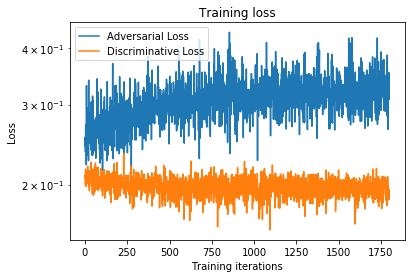

In [184]:
# adversarial_loss_map = get_2D_array_values(adversarial_loss, 0)
# discrimator_loss_map = get_2D_array_values(discrimator_loss, 0)

ax = pd.DataFrame(
    {
        'Adversarial Loss': adversarial_loss,
        'Discriminative Loss': discrimator_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Training iterations")
ax.set_ylabel("Loss")

In [185]:
targets = test.close[7:]
preds = gan.predict(X_test).squeeze()

In [186]:
# Should look at other metrics as well (MSE, RMSE, Accuracy)
metrics.mean_absolute_error(preds, y_test)

0.40974441161510156

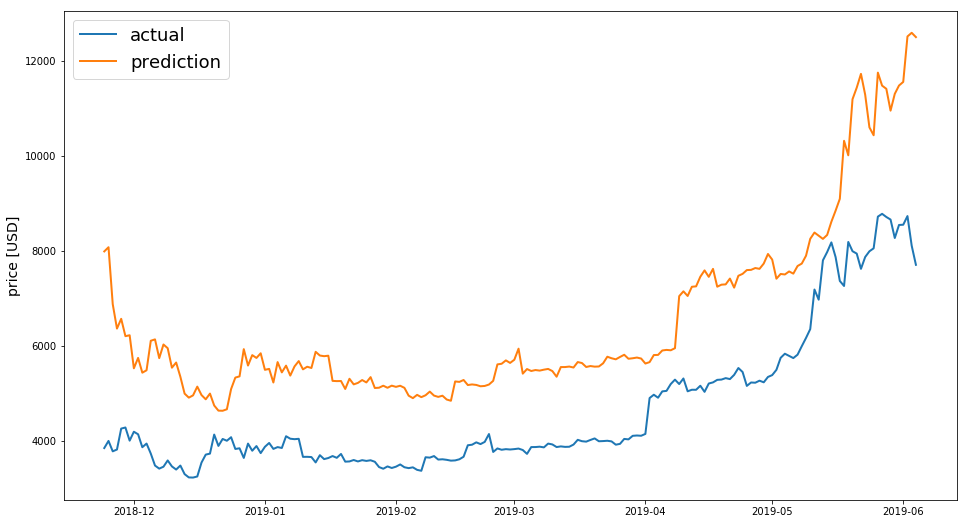

In [187]:
preds = test.close.values[:-7] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

line_plot(targets, preds, 'actual', 'prediction')

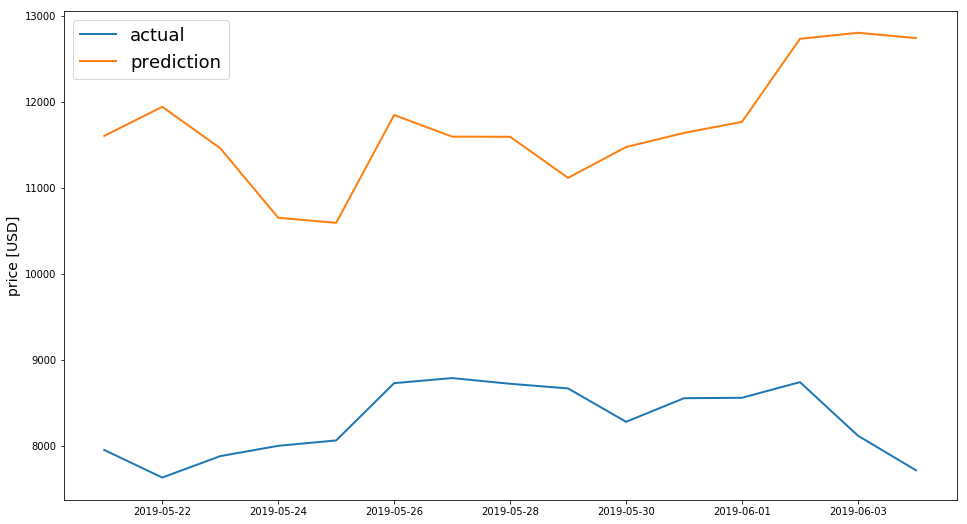

In [175]:
n_points = 15

line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction')